## CAE for feature extraction and MLP for recognition

In [ ]:
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import backend as K

### CIFAR-10 dataset used

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


### Defining the models

In [ ]:
# Normalize and convert to float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the input shape
input_img = Input(shape=(32, 32, 3))

# Encoder part of the CAE
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)

# Flatten the encoded output for MLP
flatten = Flatten()(encoded)

# Create a model for encoding features
encoder_model = Model(input_img, flatten)

# Obtain encoded features for training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
flatten_train_np = encoder_model.predict(x_train)
flatten_val_np = encoder_model.predict(x_val)

# MLP for recognition
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(flatten_train_np.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the MLP
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

313/313 [==============================] - 1s 2ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 41802 (163.29 KB)
Trainable params: 41802 (163.29 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

## Training

In [ ]:
# Train the MLP on the encoded features
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mlp_history = mlp.fit(flatten_train_np, y_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(flatten_val_np, y_val),
                      callbacks=[early_stopping_monitor])

Epoch 1/100
800/800 [==============================] - 6s 4ms/step - loss: 2.1288 - accuracy: 0.1894 - val_loss: 1.9936 - val_accuracy: 0.2756
Epoch 2/100
800/800 [==============================] - 2s 3ms/step - loss: 1.9963 - accuracy: 0.2497 - val_loss: 1.8955 - val_accuracy: 0.3006
Epoch 3/100
800/800 [==============================] - 2s 3ms/step - loss: 1.9241 - accuracy: 0.2837 - val_loss: 1.8131 - val_accuracy: 0.3473
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 1.8729 - accuracy: 0.3079 - val_loss: 1.7707 - val_accuracy: 0.3588
Epoch 5/100
800/800 [==============================] - 2s 3ms/step - loss: 1.8414 - accuracy: 0.3216 - val_loss: 1.7340 - val_accuracy: 0.3786
Epoch 6/100
800/800 [==============================] - 3s 4ms/step - loss: 1.8193 - accuracy: 0.3288 - val_loss: 1.7071 - val_accuracy: 0.3873
Epoch 7/100
800/800 [==============================] - 3s 4ms/step - loss: 1.7994 - accuracy: 0.3421 - val_loss: 1.7080 - val_accuracy: 0.3936

In [ ]:
# Define the CAE model
decoded = Dense(256, activation='relu')(flatten)
decoded = Reshape((4, 4, 16))(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

cae = Model(input_img, decoded)
cae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624

In [ ]:
# Train the CAE
early_stopping_monitor_cae = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
cae_history = cae.fit(x_train, x_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(x_val, x_val),
                      callbacks=[early_stopping_monitor_cae])

Epoch 1/100
800/800 [==============================] - 12s 8ms/step - loss: 0.0212 - accuracy: 0.5735 - val_loss: 0.0154 - val_accuracy: 0.6079
Epoch 2/100
800/800 [==============================] - 6s 7ms/step - loss: 0.0145 - accuracy: 0.6316 - val_loss: 0.0137 - val_accuracy: 0.6099
Epoch 3/100
800/800 [==============================] - 5s 7ms/step - loss: 0.0133 - accuracy: 0.6425 - val_loss: 0.0130 - val_accuracy: 0.6405
Epoch 4/100
800/800 [==============================] - 6s 8ms/step - loss: 0.0125 - accuracy: 0.6704 - val_loss: 0.0120 - val_accuracy: 0.6708
Epoch 5/100
800/800 [==============================] - 5s 7ms/step - loss: 0.0118 - accuracy: 0.6967 - val_loss: 0.0115 - val_accuracy: 0.7042
Epoch 6/100
800/800 [==============================] - 6s 8ms/step - loss: 0.0113 - accuracy: 0.7065 - val_loss: 0.0111 - val_accuracy: 0.7074
Epoch 7/100
800/800 [==============================] - 5s 6ms/step - loss: 0.0109 - accuracy: 0.7113 - val_loss: 0.0111 - val_accuracy: 0.717

313/313 [==============================] - 0s 2ms/step
Test Loss: 23.8686
Test Accuracy: 0.1041
313/313 [==============================] - 1s 2ms/step


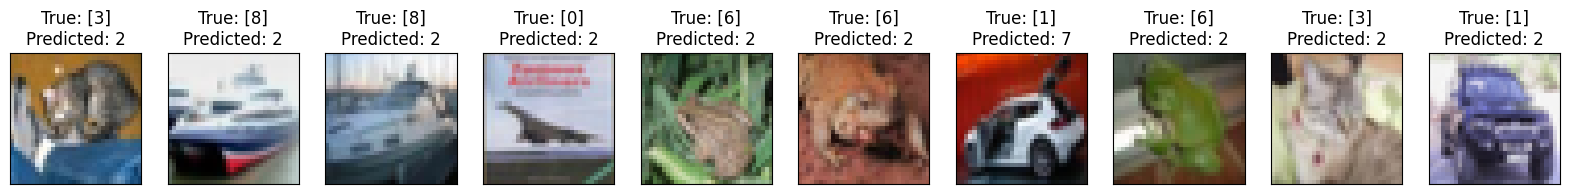

In [ ]:
# Evaluate MLP on test set
flatten_test_np = encoder_model.predict(x_test)
test_loss, test_accuracy = mlp.evaluate(flatten_test_np, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Show results
decoded_data = cae.predict(x_test)
mlp_predictions = mlp.predict(flatten_test_np)

# Display some MLP predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"True: {y_test[i]}\nPredicted: {np.argmax(mlp_predictions[i])}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Results ;-
The main obstacle is the high(very) loss and very low accuracy
## Facing this Loss MLP , our CAE is working fine.

following has better accucracy but error in representing:-


## Alternative 1:- The CAE is not explicitly defined

In [ ]:
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import backend as K




# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize and convert to float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the input shape
input_img = Input(shape=(32, 32, 3))

# Encoder part of the CAE
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# ... (previous code)

# Flatten the encoded output for MLP
flatten = Flatten()(encoded)

# Create a model for encoding features
encoder_model = Model(input_img, flatten)

# Obtain encoded features for training and validation sets
flatten_train_np = encoder_model.predict(x_train)
flatten_val_np = encoder_model.predict(x_val)

# MLP for recognition
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(flatten_train_np.shape[1],)),  # Adjust the input shape
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the MLP
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

# Train the MLP on the encoded features
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mlp_history = mlp.fit(flatten_train_np, y_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(flatten_val_np, y_val),
                      callbacks=[early_stopping_monitor])


# Visualize MLP training history
plt.plot(mlp_history.history['val_loss'])
plt.title('MLP Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

plt.plot(mlp_history.history['val_accuracy'])
plt.title('MLP Validation accuracy history')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.show()

# ... (previous code)

# Define the CAE model (assuming cae is your autoencoder model)
cae = Model(input_img, decoded)

# Flatten the encoded output for MLP
flatten_test_np = encoder_model.predict(x_test)

# Evaluate MLP on test set
test_loss, test_accuracy = mlp.evaluate(flatten_test_np, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Show results
decoded_data = cae.predict(x_test)
mlp_predictions = mlp.predict(flatten_test_np)

# Display original and reconstructed images
display_images(x_test, decoded_data)

# Display some MLP predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.title(f"True: {y_test[i]}\nPredicted: {np.argmax(mlp_predictions[i])}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Alternate 2:- The CAE is explicitly defined with a specific architecture for decoding

In [ ]:
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize and convert to float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the input shape
input_img = Input(shape=(32, 32, 3))

# Encoder part of the CAE
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)

# Flatten the encoded output for MLP
flatten = Flatten()(encoded)

# Create a model for encoding features
encoder_model = Model(input_img, flatten)

# Obtain encoded features for training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
flatten_train_np = encoder_model.predict(x_train)
flatten_val_np = encoder_model.predict(x_val)

# MLP for recognition with 400 neurons in the second layer
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(flatten_train_np.shape[1],)),
    Dropout(0.5),
    Dense(400, activation='relu'),  # Updated to have 400 neurons
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the MLP
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

# Train the MLP on the encoded features
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mlp_history = mlp.fit(flatten_train_np, y_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(flatten_val_np, y_val),
                      callbacks=[early_stopping_monitor])

# Define the CAE model
decoded = Dense(256, activation='relu')(flatten)
decoded = Reshape((4, 4, 16))(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

cae = Model(input_img, decoded)
cae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cae.summary()

# Train the CAE
early_stopping_monitor_cae = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
cae_history = cae.fit(x_train, x_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(x_val, x_val),
                      callbacks=[early_stopping_monitor_cae])

# Evaluate MLP on test set
flatten_test_np = encoder_model.predict(x_test)
test_loss, test_accuracy = mlp.evaluate(flatten_test_np, y_test, verbose=0)
print(f'MLP Test Loss: {test_loss:.4f}')
print(f'MLP Test Accuracy: {test_accuracy:.4f}')

# Evaluate CAE on test set
cae_test_loss, cae_test_accuracy = cae.evaluate(x_test, x_test, verbose=0)
print(f'CAE Test Loss: {cae_test_loss:.4f}')
print(f'CAE Test Accuracy: {cae_test_accuracy:.4f}')

# Show results
decoded_data = cae.predict(x_test)
mlp_predictions = mlp.predict(flatten_test_np)

# Display some MLP predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"True: {y_test[i]}\nPredicted: {np.argmax(mlp_predictions[i])}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


313/313 [==============================] - 3s 10ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 41802 (163.29 KB)
Trainable params: 41802 (163.29 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________

# New approach - BEST approach yet


In [1]:
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 8s 0us/step


In [ ]:

# Normalize and convert to float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the input shape
input_img = Input(shape=(32, 32, 3))

# Encoder part of the CAE
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)

# Flatten the encoded output for MLP
flatten = Flatten()(encoded)

# Create a model for encoding features
encoder_model = Model(input_img, flatten)

# Obtain encoded features for training and validation sets
flatten_train_np = encoder_model.predict(x_train)
flatten_test_np = encoder_model.predict(x_test)

# MLP for recognition
mlp = Sequential([
    Dense(400, activation='relu', input_shape=(flatten_train_np.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the MLP
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

 511/1563 [========>.....................] - ETA: 17s

In [ ]:


# Train the MLP on the encoded features
x_train, x_val, y_train, y_val = train_test_split(flatten_train_np, y_train, test_size=0.2, random_state=42)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mlp_history = mlp.fit(x_train, y_train,
                      epochs=100,
                      batch_size=50,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping_monitor])


In [ ]:

# Visualize MLP training history
plt.plot(mlp_history.history['val_loss'])
plt.title('MLP Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

plt.plot(mlp_history.history['val_accuracy'])
plt.title('MLP Validation accuracy history')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.show()

In [ ]:


# Evaluate MLP on test set
test_loss, test_accuracy = mlp.evaluate(flatten_test_np, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

